In [1]:
import pandas as pd
import numpy as np
from keras.utils import np_utils, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_vggface.vggface import VGGFace
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# IMPORTING DATA

In [2]:
main_folder = 'input/adiencedb/inside/'
images_folder = main_folder + 'faces/'
weights_folder = 'weights/'

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
K_FOLD = 5

In [3]:
df_0 = pd.read_csv((main_folder + "fold_0_data.txt"), sep="\t")
df_1 = pd.read_csv((main_folder + "fold_1_data.txt"), sep="\t")
df_2 = pd.read_csv((main_folder + "fold_2_data.txt"), sep="\t")
df_3 = pd.read_csv((main_folder + "fold_3_data.txt"), sep="\t")
df_4 = pd.read_csv((main_folder + "fold_4_data.txt"), sep="\t")
df_4

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,115321157@N03,12111738395_a7f715aa4e_o.jpg,1744,"(4, 6)",m,663,997,637,638,-95,0,129
1,115321157@N03,12112413505_0aea8e17c6_o.jpg,1745,"(48, 53)",m,505,846,433,433,-95,0,72
2,115321157@N03,12112392255_995532c2f0_o.jpg,1744,"(4, 6)",m,517,1185,383,383,0,0,70
3,115321157@N03,12112392255_995532c2f0_o.jpg,1746,"(25, 32)",m,2247,688,376,376,0,30,67
4,115321157@N03,12112392255_995532c2f0_o.jpg,1747,"(25, 32)",m,1421,667,325,325,0,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...
3811,7153718@N04,11598838386_349a0d4849_o.jpg,2282,None,NaN,596,460,1472,1473,-75,0,30
3812,7153718@N04,11598166203_c70bb34c80_o.jpg,2283,None,NaN,1179,755,331,331,5,0,108
3813,7153718@N04,11598166203_c70bb34c80_o.jpg,2282,None,NaN,1201,1179,293,293,5,0,99
3814,7153718@N04,11598145163_733cb99713_o.jpg,2282,None,NaN,1027,946,408,408,-85,0,49


In [4]:
df_0.dropna(inplace=True)
df_1.dropna(inplace=True)
df_2.dropna(inplace=True)
df_3.dropna(inplace=True)
df_4.dropna(inplace=True)

df_0['user_id'] = df_0['user_id'] + r'/coarse_tilt_aligned_face.' + df_0['face_id'].astype(str) + '.' + df_0["original_image"]
df_1['user_id'] = df_1['user_id'] + r'/coarse_tilt_aligned_face.' + df_1['face_id'].astype(str) + '.' + df_1["original_image"]
df_2['user_id'] = df_2['user_id'] + r'/coarse_tilt_aligned_face.' + df_2['face_id'].astype(str) + '.' + df_2["original_image"]
df_3['user_id'] = df_3['user_id'] + r'/coarse_tilt_aligned_face.' + df_3['face_id'].astype(str) + '.' + df_3["original_image"]
df_4['user_id'] = df_4['user_id'] + r'/coarse_tilt_aligned_face.' + df_4['face_id'].astype(str) + '.' + df_4["original_image"]

df_0.reset_index(inplace=True)
df_1.reset_index(inplace=True)
df_2.reset_index(inplace=True)
df_3.reset_index(inplace=True)
df_4.reset_index(inplace=True)

df_0 = df_0[df_0.age != "None"]
df_1 = df_1[df_1.age != "None"]
df_2 = df_2[df_2.age != "None"]
df_3 = df_3[df_3.age != "None"]
df_4 = df_4[df_4.age != "None"]

df_0 = df_0[df_0.gender != "u"]
df_1 = df_1[df_1.gender != "u"]
df_2 = df_2[df_2.gender != "u"]
df_3 = df_3[df_3.gender != "u"]
df_4 = df_4[df_4.gender != "u"]

df_4

,index,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,0,115321157@N03/coarse_tilt_aligned_face.1744.12...,12111738395_a7f715aa4e_o.jpg,1744,"(4, 6)",m,663,997,637,638,-95,0,129
1,1,115321157@N03/coarse_tilt_aligned_face.1745.12...,12112413505_0aea8e17c6_o.jpg,1745,"(48, 53)",m,505,846,433,433,-95,0,72
2,2,115321157@N03/coarse_tilt_aligned_face.1744.12...,12112392255_995532c2f0_o.jpg,1744,"(4, 6)",m,517,1185,383,383,0,0,70
3,3,115321157@N03/coarse_tilt_aligned_face.1746.12...,12112392255_995532c2f0_o.jpg,1746,"(25, 32)",m,2247,688,376,376,0,30,67
4,4,115321157@N03/coarse_tilt_aligned_face.1747.12...,12112392255_995532c2f0_o.jpg,1747,"(25, 32)",m,1421,667,325,325,0,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3726,3787,101515718@N03/coarse_tilt_aligned_face.2280.10...,10587826073_6663f5b654_o.jpg,2280,"(25, 32)",f,718,748,492,492,0,0,63
3727,3788,101515718@N03/coarse_tilt_aligned_face.2278.10...,10587571495_a61785cd06_o.jpg,2278,"(25, 32)",m,48,472,768,768,-15,0,25
3728,3789,101515718@N03/coarse_tilt_aligned_face.2279.10...,10587571495_a61785cd06_o.jpg,2279,"(25, 32)",f,950,0,692,687,-5,0,27
3729,3790,50458575@N08/coarse_tilt_aligned_face.2281.942...,9426695459_9e8b347604_o.jpg,2281,"(25, 32)",f,831,895,899,899,0,15,59


In [5]:
folds = [df_0, df_1, df_2, df_3, df_4]
df_train = pd.DataFrame()
for sel_fold in range(len(folds)):
    df_train = pd.concat([df_train,folds[sel_fold]])

(25, 32)
(38, 43)
(4, 6)
(60, 100)
(15, 20)
(48, 53)
(8, 12)
(0, 2)
(38, 48)
35
3
55
58
22
13
45
36
23
(38, 42)
(8, 23)
(27, 32)
57
2
29
34
42
46


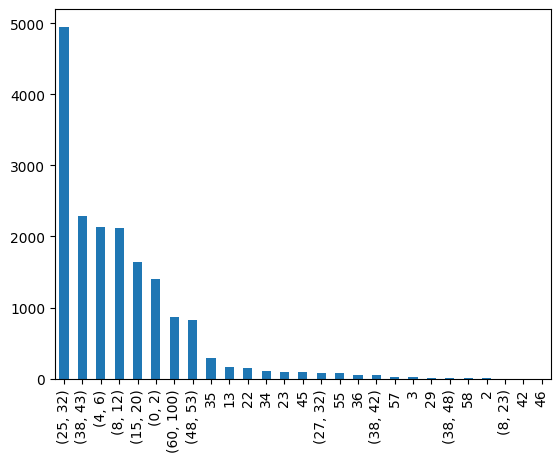

In [6]:
df_train = df_train[df_train.age != "None"]

df_train['age'].value_counts().plot(kind='bar')

x = df_train['age'].unique()
num =0
for i in x:
#     print(f"df_train.loc[(df_train.age == '{i}'),'age']='{num}'")
    num+=1
    print(i)
    


In [7]:
def consolidate_age(df_train):
    
    df_train.loc[(df_train.age == '(38, 42)'),'age']='(38, 43)'
    df_train.loc[(df_train.age == '(8, 12)'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '(15, 20)'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '(27, 32)'),'age']='(25, 32)'

    df_train.loc[(df_train.age == '2'),'age']='(0, 6)'
    df_train.loc[(df_train.age == '3'),'age']='(0, 6)'
    df_train.loc[(df_train.age == '(0, 2)'),'age']='(0, 6)'
    df_train.loc[(df_train.age == '(4, 6)'),'age']='(0, 6)'

    df_train.loc[(df_train.age == '35'),'age']='(34, 36)'
    df_train.loc[(df_train.age == '55'),'age']='(55, 58)'
    df_train.loc[(df_train.age == '58'),'age']='(55, 58)'
    df_train.loc[(df_train.age == '22'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '13'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '45'),'age']='(38, 48)'
    df_train.loc[(df_train.age == '36'),'age']='(34, 36)'
    df_train.loc[(df_train.age == '23'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '57'),'age']='(55, 58)'
    df_train.loc[(df_train.age == '29'),'age']='(25, 32)'
    df_train.loc[(df_train.age == '34'),'age']='(34, 36)'
    df_train.loc[(df_train.age == '42'),'age']='(38, 48)'
    df_train.loc[(df_train.age == '46'),'age']='(38, 48)'

    df_train.loc[(df_train.age == '(38, 43)'),'age']='(38, 48)'
    
    df_train.loc[(df_train.age == '(60, 100)'),'age']=61
    df_train.loc[(df_train.age == '(48, 53)'),'age']=49
    df_train.loc[(df_train.age == '(0, 6)'),'age']=1
    df_train.loc[(df_train.age == '(38, 48)'),'age']=39
    df_train.loc[(df_train.age == '(8, 23)'),'age']=9
    df_train.loc[(df_train.age == '(34, 36)'),'age']=35
    df_train.loc[(df_train.age == '(55, 58)'),'age']=56
    df_train.loc[(df_train.age == '(25, 32)'),'age']=26
    
    df_train.loc[(df_train.gender == 'm'),'gender']="male"
    df_train.loc[(df_train.gender == 'f'),'gender']="female"
    

#     df_train['age'] = np.asarray(df_train['age']).astype(np.float32)
#     df_train['age'] = df_train['age'].astype(np.array)

#     df_train.loc[(df_train.age == df_train.age),'age']=df_train['age'].astype("category")
    
    return df_train

In [8]:

for fold in folds:
    fold = consolidate_age(fold)

## Data Preprocessing

In [9]:
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
dataset_dict = {
    'gender': {
        0: 'male',
        1: 'female'
    }
}
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender'].items())

In [10]:
folds = [df_0, df_1, df_2, df_3, df_4]
df_train = pd.DataFrame()
for sel_fold in range(len(folds)):
    df_train = pd.concat([df_train,folds[sel_fold]])

In [12]:
from keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
        self.USE_AGE = False
        self.USE_GENDER = True
        self.USE_RACE = False
        
        
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]        
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        
        if self.USE_GENDER:       
            self.df['gender'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        if self.USE_AGE:
            self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])        
        if self.USE_AGE:       
            self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        
        rel_path = "input/adiencedb/inside/faces"
        img_path = os.path.join(rel_path,img_path)
        

        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                if self.USE_AGE:   
                    age = person['age']
                if self.USE_RACE:   
                    race = person['race_id']
                if self.USE_GENDER:   
                    gender = person['gender']
                file = person['user_id']
                
                im = self.preprocess_image(file)
                

                
                if self.USE_AGE:   
                    ages.append(age / self.max_age)
                if self.USE_RACE:   
                    races.append(to_categorical(race, len(dataset_dict['race_id'])))
                if self.USE_GENDER:   
                    genders.append(to_categorical(gender, len(dataset_dict['gender'])))

                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    
                    to_yield = []
                    
                    if self.USE_AGE:   
                        to_yield.append(np.array(ages))
                    if self.USE_RACE:   
                        to_yield.append(np.array(races))
                    if self.USE_GENDER:   
                        to_yield.append(np.array(genders))
                    
                    if len(to_yield) <=1:
                        to_yield = to_yield[0]         
                    
                    yield np.array(images), to_yield


                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df_train)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes() 